# Seminar 5. Variance gamma & quasi random numbers

_Dimitri Sotnikov_

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm


color_cycle = ["#5b6c64", "#B56246", "#322B4D", "#28BC9C", "#71074E"]
plt.rcParams["figure.figsize"]        = ((1 + np.sqrt(5)) / 2 * 5, 5)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True
plt.rcParams['axes.prop_cycle']       = matplotlib.cycler(color=color_cycle)

## Part 1. Variance gamma process

Let $W$ be a standard Brownian motion and $B_t = \vartheta t + \sigma W_t$.

The _variance gamma process_ $X$ is defined by
$$
X_t = B_{\gamma_t} = \vartheta \gamma_t + \sigma W_{\gamma_t},
$$
where $\gamma$ is a gamma process with parameters $\alpha = \dfrac{1}{\nu}$ and $\beta = \nu$ independent of $W$.

The stock price under the risk-neutral measure is given by
$$
S_t = S_0 \exp\left((r - q + \omega)t + X_t\right),
$$
where $\omega = \dfrac{1}{\nu}\log\left(1 - \vartheta \nu - \dfrac12\sigma^2\nu\right)$.

#### Simulation of $(X_{t_i},S_{t_i})_{i = 1, \ldots, n}$

1. $X_0 = 0, S_0 = S_0.$
2. To pass from $t_i$ to $t_{i+1} = t_i + \Delta t_{i+1}$:
\begin{align}
 \Delta \gamma_{i + 1} &\sim \Gamma\left(\dfrac{\Delta t_{i+1}}{\nu}, \nu\right), \\
 \Delta X_{i + 1} &= \vartheta \Delta \gamma_{i + 1} + \sigma\sqrt{\Delta \gamma_{i + 1}} Z_{i + 1}, \quad Z_{i + 1} \sim \mathcal{N}(0, 1), \\
 \Delta \log S_{t_{i + 1}} &= (r - q + \omega)\Delta t_{i+1} + \Delta X_{i + 1}.
\end{align}

In [1]:
def standard_brownian_motion_1d(t_grid, size, rng=None):
    """
    Simulates a "size" trajectories of a BM on t_grid.

    Returns: An array of shape (size, len(t_grid)).
    """
    if rng is None:
        rng = np.random.default_rng(seed=42)
    dt = np.diff(np.concatenate([[0], t_grid]))
    dW = rng.normal(size=(size, len(t_grid))) * np.reshape(np.sqrt(dt), (1, -1))
    W = np.cumsum(dW, axis=1)
    return W

def geometric_brownian_motion(t_grid, size, rng=None, drift=0, vol=1, init_val=1):
    """
    Simulates "size" trajectoriees of the solution to
    dX_t / X_t = drift * dt + vol * dW_t,
    X_0 = init_val,
    on the given time grid.

    Returns: An array of shape (size, len(t_grid)).
    """
    if rng is None:
        rng = np.random.default_rng(seed=42)
    W = standard_brownian_motion_1d(t_grid=t_grid, size=size, rng=rng)
    X = init_val * np.exp((drift - 0.5 * vol**2) * np.reshape(t_grid, (1, -1)) + vol * W)
    return X

In [2]:
def simulate_variance_gamma(t_grid, size, theta, nu, sigma, r, q, S0, rng=None):
    """
    Simulates the "size" price trajectories in the variance gamma model on the given uniform time grid.

    Returns: An array of shape (size, len(t_grid)).
    """
    if rng is None:
        rng = np.random.default_rng(seed=42)

    dt = t_grid[1] - t_grid[0]
    omega = 1 / nu * np.log(1 - theta * nu - sigma**2 * nu / 2)

    Z = rng.normal(size=(size, len(t_grid) - 1))
    dGamma = rng.gamma(size=(size, len(t_grid) - 1), shape=dt / nu, scale=nu)
    dX = theta * dGamma + sigma * np.sqrt(dGamma) * Z

    S = np.ones((size, len(t_grid))) * S0
    S[:, 1:] = S0 * np.exp(np.cumsum((r - q + omega) * dt + dX, axis=1))
    return S

In [3]:
S0 = 100
sigma = 0.2
nu = 0.2
theta = -0.1

r = 0.01
q = 0.02

T = 1
m = 500

In [4]:
t_grid = np.linspace(0, T, m + 1)
size = 2

NameError: name 'np' is not defined

In [ ]:
rng1 = np.random.default_rng(seed=42)
rng2 = np.random.default_rng(seed=42)

prices_bs = geometric_brownian_motion(t_grid=t_grid, size=size, rng=rng1, drift=r-q, vol=sigma, init_val=S0)
prices_vg = simulate_variance_gamma(t_grid=t_grid, size=size, theta=theta, nu=nu, sigma=sigma, r=r, q=q, S0=S0, rng=rng2)

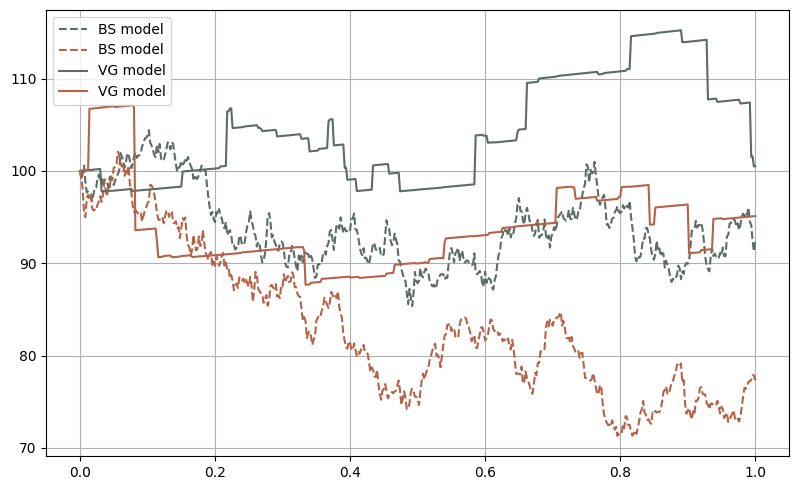

In [ ]:
for i, traj_bs in enumerate(prices_bs):
    plt.plot(t_grid, traj_bs, "--", color=color_cycle[i], label="BS model")

for i, traj_vg in enumerate(prices_vg):
    plt.plot(t_grid, traj_vg, color=color_cycle[i], label="VG model")

plt.legend()
plt.show()

##### Sanity check: expectation

In [ ]:
rng1 = np.random.default_rng(seed=42)
rng2 = np.random.default_rng(seed=42)

size = 10**6
t_grid = np.linspace(0, T, 10 + 1)
prices_bs = geometric_brownian_motion(t_grid=t_grid, size=size, rng=rng1, drift=r-q, vol=sigma, init_val=S0)
prices_vg = simulate_variance_gamma(t_grid=t_grid, size=size, theta=theta, nu=nu, sigma=sigma, r=r, q=q, S0=S0, rng=rng2)

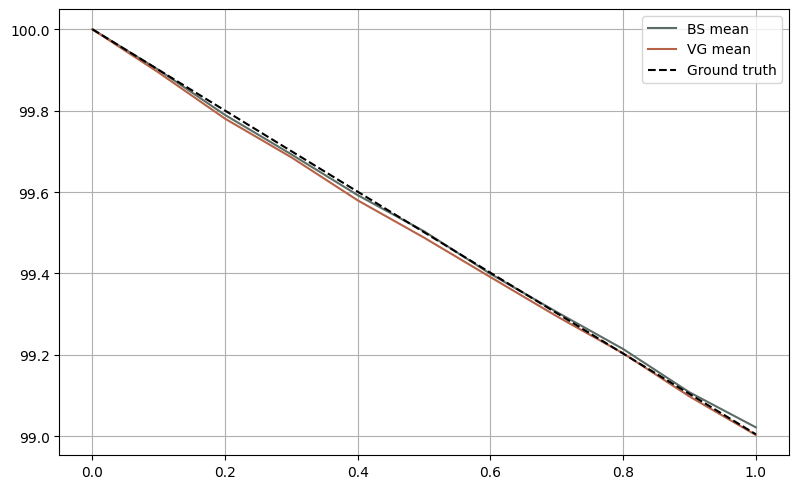

In [ ]:
plt.plot(t_grid, np.mean(prices_bs, axis=0), label="BS mean")
plt.plot(t_grid, np.mean(prices_vg, axis=0), label="VG mean")
plt.plot(t_grid, S0 * np.exp((r - q) * t_grid), "k--", label="Ground truth")

plt.legend()
plt.show()

### Pricing a European option with the VG model

In [ ]:
def put_payoff(S, K):
    return np.maximum(K - S, 0)

In [ ]:
K = 95
T = 1
m = 1

size = 10**6
t_grid = np.array([0, T])
rng = np.random.default_rng(seed=42)

prices_vg = simulate_variance_gamma(t_grid=t_grid, size=size, theta=theta, nu=nu, sigma=sigma, r=r, q=q, S0=S0, rng=rng)[:, -1]
discounted_payoffs = np.exp(-r * T) * put_payoff(S=prices_vg, K=K)

In [ ]:
discounted_payoffs

array([ 0.        , 22.65167982,  0.        , ..., 32.15620817,
       15.63043082,  0.        ])

In [ ]:
def plot_convergence_diagram(sample, fisrt_idx = 100, ax = None, label = "MC sample", confidence_level = 0.95, plot_ci = False, **kwargs):
        # ns = [1, 2, 3, ..., len(sample)] - массив номеров итераций
    ns = np.arange(1, len(sample) + 1)
    
    # x = log(n) - логарифм номера итерации (для логарифмической шкалы)
    # Формула: xₙ = ln(n) для n ≥ first_idx
    x = np.log(ns)[fisrt_idx:]
    
    # y = (X₁ + X₂ + ... + Xₙ)/n - последовательные средние (закон больших чисел)
    # Это оценка E[X] по n первым точкам
    y = (np.cumsum(sample) / ns)[fisrt_idx:]
    
    # 2. Создание графика
    if ax is None:
        fig, ax = plt.subplots()
    
    # Основной график: log(n) vs оценка среднего
    ax.plot(x, y, label=label, **kwargs)
    
    # 3. Доверительные интервалы (если требуется)
    if plot_ci:
        # mean_sq = (X₁² + X₂² + ... + Xₙ²)/n - среднее квадратов
        mean_sq = (np.cumsum(sample**2) / ns)[fisrt_idx:]
        
        # Квантиль нормального распределения для заданного уровня доверия
        # Например, для 95%: Φ⁻¹((1+0.95)/2) ≈ 1.96
        quantile = norm.ppf((1 + confidence_level) / 2)
        
        # Вычисление доверительного интервала:
        # Точность = z_{α/2} * √(S²/n), где:
        # S² = (mean_sq - y²) - выборочная дисперсия
        # Формула следует из ЦПТ: √n(Yₙ-μ) ~ N(0,σ²)
        accuracy = quantile * np.sqrt((mean_sq - y**2) / ns[fisrt_idx:])
        
        # Закрашиваем область y ± accuracy
        ax.fill_between(x, y - accuracy, y + accuracy, alpha=0.3)
    
    ax.legend()
    ax.set_xlabel("$\log(n)$") 
    ax.set_ylabel("Оценка среднего")  

def mc_results(sample, confidence_level=0.95, decimals=4):
    n = len(sample)
    
    # Точечная оценка мат. ожидания: выборочное среднее
    # μ̂ = (1/n)∑Xᵢ
    mean = sample.mean()
    
    # Оценка дисперсии: исправленная выборочная дисперсия
    # σ̂² = (1/(n-1))∑(Xᵢ - μ̂)²
    var = sample.var(ddof=1)  # ddof=1 для несмещенной оценки
    
    # Квантиль нормального распределения
    # Например, для 95%: z_{0.975} ≈ 1.96
    quantile = norm.ppf((1 + confidence_level) / 2)
    
    # Полуширина доверительного интервала:
    # Δ = z_{α/2} * √(σ̂²/n)
    accuracy = quantile * np.sqrt(var / n)
    return str(np.round(mean, decimals=decimals)) + " ± " + str(np.round(accuracy, decimals=decimals))

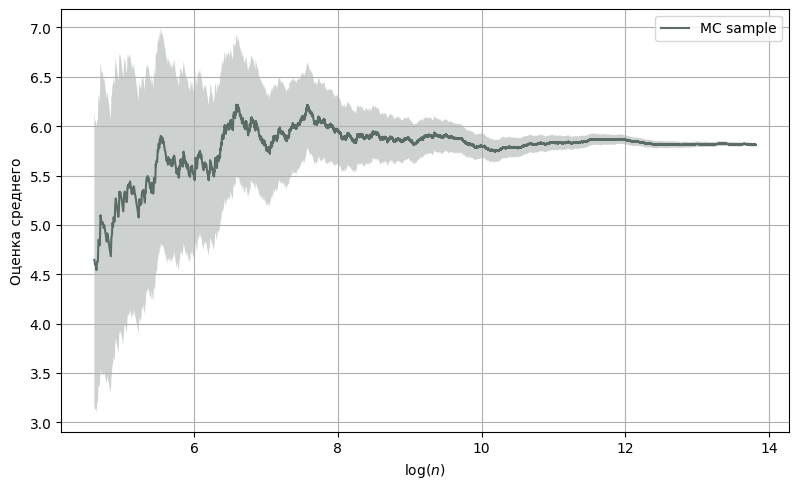

In [ ]:
plot_convergence_diagram(discounted_payoffs, plot_ci=True)

In [ ]:
for k in (4, 5, 6):
    print(f"Option price for 10^{k} samples:", mc_results(discounted_payoffs[:10**k]))

Option price for 10^4 samples: 5.8934 ± 0.1866
Option price for 10^5 samples: 5.8628 ± 0.0584
Option price for 10^6 samples: 5.8109 ± 0.0184


## Part 2. Quasi Monte Carlo

In [ ]:
from scipy.stats import qmc

In [ ]:
dim = 2
m = 8 # number of bits
size = 2**m
size

256

##### Halton sequence

In [ ]:
sampler_halton = qmc.Halton(d=dim, scramble=False)
sample_halton = sampler_halton.random(n=size)
sample_halton[:10]

array([[0.        , 0.        ],
       [0.5       , 0.33333333],
       [0.25      , 0.66666667],
       [0.75      , 0.11111111],
       [0.125     , 0.44444444],
       [0.625     , 0.77777778],
       [0.375     , 0.22222222],
       [0.875     , 0.55555556],
       [0.0625    , 0.88888889],
       [0.5625    , 0.03703704]])

##### Sobol' sequence

In [ ]:
sampler_sobol = qmc.Sobol(d=dim, scramble=False)
sample_sobol = sampler_sobol.random_base2(m=m)
sample_sobol[:10]

array([[0.    , 0.    ],
       [0.5   , 0.5   ],
       [0.75  , 0.25  ],
       [0.25  , 0.75  ],
       [0.375 , 0.375 ],
       [0.875 , 0.875 ],
       [0.625 , 0.125 ],
       [0.125 , 0.625 ],
       [0.1875, 0.3125],
       [0.6875, 0.8125]])

##### Pseudo-random numbers

In [ ]:
rng = np.random.default_rng(seed=42)
sample_pseudo_rand = rng.random((size, dim))
sample_pseudo_rand[:10]

array([[0.77395605, 0.43887844],
       [0.85859792, 0.69736803],
       [0.09417735, 0.97562235],
       [0.7611397 , 0.78606431],
       [0.12811363, 0.45038594],
       [0.37079802, 0.92676499],
       [0.64386512, 0.82276161],
       [0.4434142 , 0.22723872],
       [0.55458479, 0.06381726],
       [0.82763117, 0.6316644 ]])

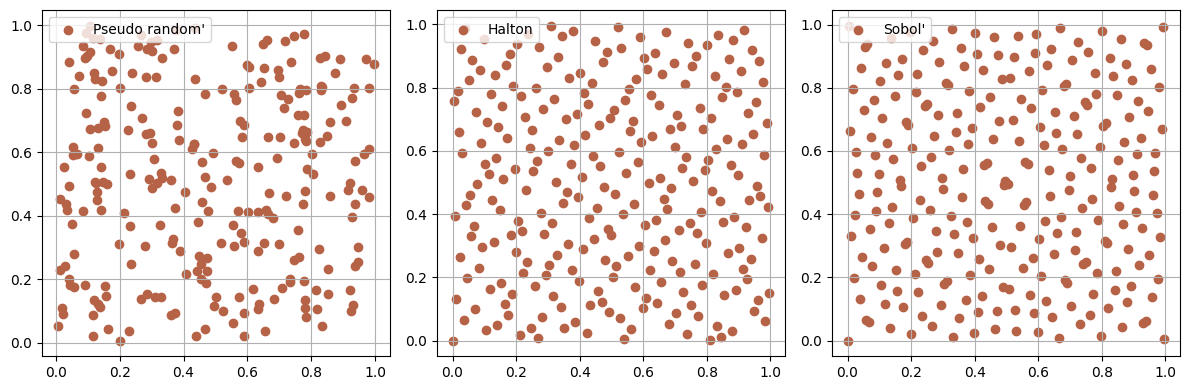

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].scatter(sample_pseudo_rand.T[0], sample_pseudo_rand.T[1], c=color_cycle[1], label="Pseudo random'")
ax[1].scatter(sample_halton.T[0], sample_halton.T[1], c=color_cycle[1], label="Halton")
ax[2].scatter(sample_sobol.T[0], sample_sobol.T[1], c=color_cycle[1], label="Sobol'")

ax[0].legend(loc=2)
ax[1].legend(loc=2)
ax[2].legend(loc=2)

#### MC convergence

Let's compute $\mathbb{E}[f(U_1, U_2)] = \mathbb{E}[\sqrt{|U_1|} U_2^2]$ via MC and QMC

In [ ]:
dim = 2
m = 15 # number of bits
size = 2**m
size

32768

In [ ]:
sampler_halton = qmc.Halton(d=dim, scramble=False)
sample_halton = sampler_halton.random(n=size)

sampler_sobol = qmc.Sobol(d=dim, scramble=False)
sample_sobol = sampler_sobol.random_base2(m=m)

rng = np.random.default_rng(seed=42)
sample_pseudo_rand = rng.random((size, dim))

In [ ]:
def f(x):
    return np.sqrt(np.abs(x[0])) * x[1]**2

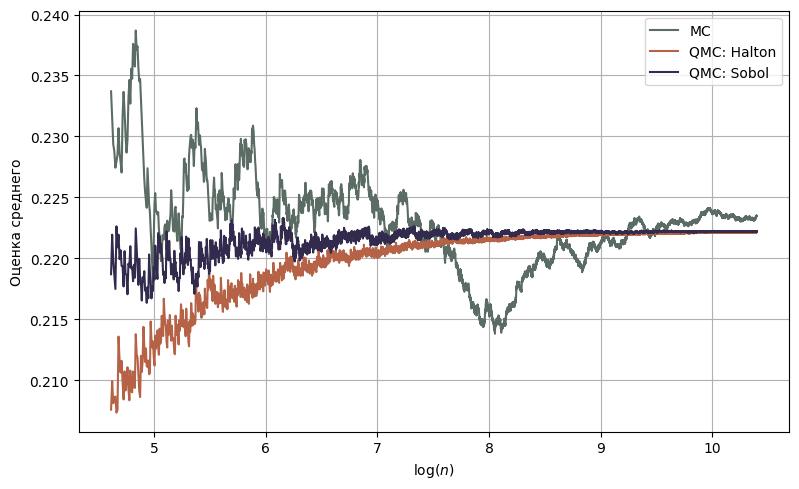

In [ ]:
f_sample_pseudo = f(sample_pseudo_rand.T)
f_sample_halton = f(sample_halton.T)
f_sample_sobol = f(sample_sobol.T)

fig, ax = plt.subplots()

plot_convergence_diagram(sample=f_sample_pseudo, ax=ax, label="MC")
plot_convergence_diagram(sample=f_sample_halton, ax=ax, label="QMC: Halton")
plot_convergence_diagram(sample=f_sample_sobol, ax=ax, label="QMC: Sobol")

#### Increasing the dimensions: $d = 200$

In [ ]:
dim = 200
m = 12 # number of bits
size = 2**m
size

4096

In [ ]:
is_scramble = True

sampler_halton = qmc.Halton(d=dim, scramble=is_scramble)
sample_halton = sampler_halton.random(n=size)

sampler_sobol = qmc.Sobol(d=dim, scramble=is_scramble)
sample_sobol = sampler_sobol.random_base2(m=m)

rng = np.random.default_rng(seed=42)
sample_pseudo_rand = rng.random((size, dim))

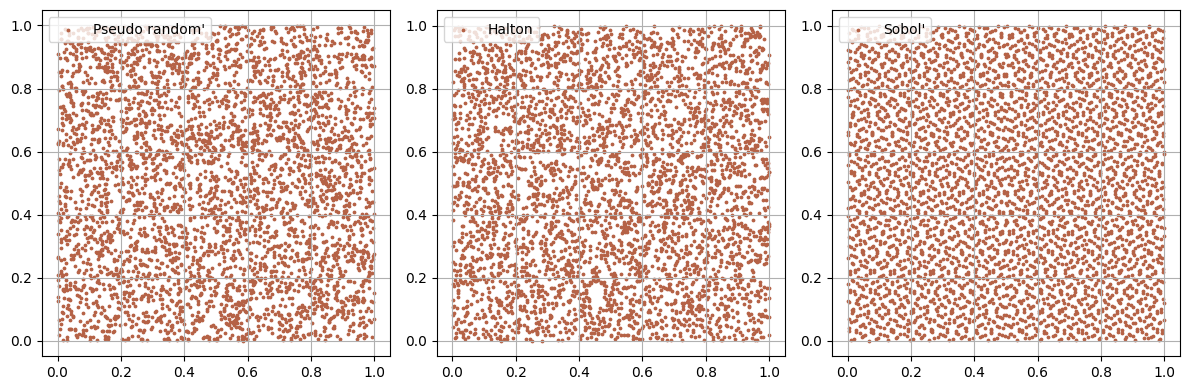

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

dim_1, dim_2 = 42, 94

ax[0].scatter(sample_pseudo_rand.T[dim_1], sample_pseudo_rand.T[dim_2], c=color_cycle[1], label="Pseudo random'", s=3)
ax[1].scatter(sample_halton.T[dim_1], sample_halton.T[dim_2], c=color_cycle[1], label="Halton", s=3)
ax[2].scatter(sample_sobol.T[dim_1], sample_sobol.T[dim_2], c=color_cycle[1], label="Sobol'", s=3)

ax[0].legend(loc=2)
ax[1].legend(loc=2)
ax[2].legend(loc=2)

### Warning: why dimension is important?

In [ ]:
is_scramble = False

dim = 1
m = 14 # number of bits
size = 2**m

sampler_halton = qmc.Halton(d=dim, scramble=is_scramble)
sample_halton = sampler_halton.random(n=size).squeeze()
sample_halton[:9]

array([0.    , 0.5   , 0.25  , 0.75  , 0.125 , 0.625 , 0.375 , 0.875 ,
       0.0625])

Let's compute $\mathrm{Cov}(U_1, U_2)$ between independend $U_1, U_2 \sim \mathcal{U}(0, 1)$

In [ ]:
U_sample = np.zeros((2, size // 2))
U_sample[0] = sample_halton[0:size // 2]
U_sample[1] = sample_halton[size // 2:]

In [ ]:
np.corrcoef(U_sample)

array([[1., 1.],
       [1., 1.]])

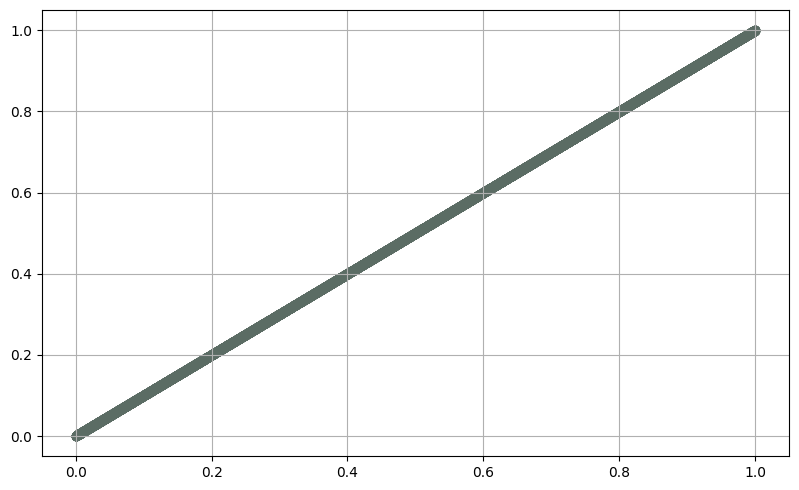

In [ ]:
plt.scatter(U_sample[0], U_sample[1])

##### Let's do it properly

In [ ]:
is_scramble = False

dim = 2
m = 14 # number of bits
size = 2**m

sampler_halton = qmc.Halton(d=dim, scramble=is_scramble)
sample_halton = sampler_halton.random(n=size).squeeze()
sample_halton[:9]

array([[0.        , 0.        ],
       [0.5       , 0.33333333],
       [0.25      , 0.66666667],
       [0.75      , 0.11111111],
       [0.125     , 0.44444444],
       [0.625     , 0.77777778],
       [0.375     , 0.22222222],
       [0.875     , 0.55555556],
       [0.0625    , 0.88888889]])

In [ ]:
np.corrcoef(sample_halton.T)

array([[ 1.00000000e+00, -2.97305496e-05],
       [-2.97305496e-05,  1.00000000e+00]])

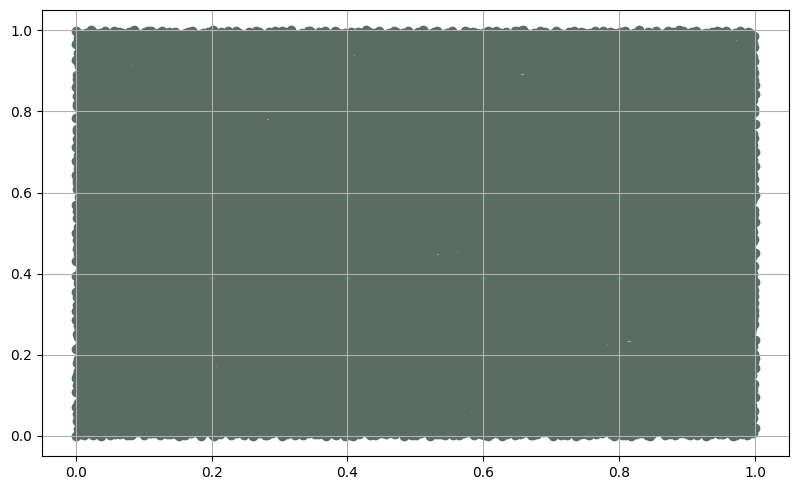

In [ ]:
plt.scatter(sample_halton.T[0], sample_halton.T[1])